In [ ]:
!

Wed Jul 13 14:13:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 기본 베이스라인 

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
!pip install markupsafe==2.0.1
!pip install pycaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
from pycaret.classification import * 

## 1단계 데이터 다운로드 

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ./

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-apr-2022
!unzip /content/tabular-playground-series-apr-2022.zip 

 93% 159M/171M [00:01<00:00, 99.4MB/s]
100% 171M/171M [00:01<00:00, 118MB/s] 
Archive:  /content/tabular-playground-series-apr-2022.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_labels.csv        


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob 
from tqdm.auto import tqdm

In [ ]:
file_dirs = glob('*.csv')

df = []
for dir in file_dirs:
  exec(f"{dir.split('.')[0]}=pd.read_csv('{dir}')")
  df.append(dir.split('.')[0])

## 2단계 x,y 데이터 준비 

In [ ]:
train_labels

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


In [ ]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


### 컬럼 제거 
- subject, step 제거 

In [ ]:
train = train.drop(columns = ['subject','step']).reset_index(drop=True)

### 결측치 확인 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 14 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   sensor_00  1558080 non-null  float64
 2   sensor_01  1558080 non-null  float64
 3   sensor_02  1558080 non-null  float64
 4   sensor_03  1558080 non-null  float64
 5   sensor_04  1558080 non-null  float64
 6   sensor_05  1558080 non-null  float64
 7   sensor_06  1558080 non-null  float64
 8   sensor_07  1558080 non-null  float64
 9   sensor_08  1558080 non-null  float64
 10  sensor_09  1558080 non-null  float64
 11  sensor_10  1558080 non-null  float64
 12  sensor_11  1558080 non-null  float64
 13  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 166.4 MB


In [ ]:
train.isnull().sum()

sequence     0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

###이상치 확인 
- (질문)스케일링 이랑도 관련 되어 이러한 시계열을 처리할 때 민맥스를 전체 데이터를 기준으로 해야 하는지, 시퀸스 별로 스케일링을 해야 하는 지 

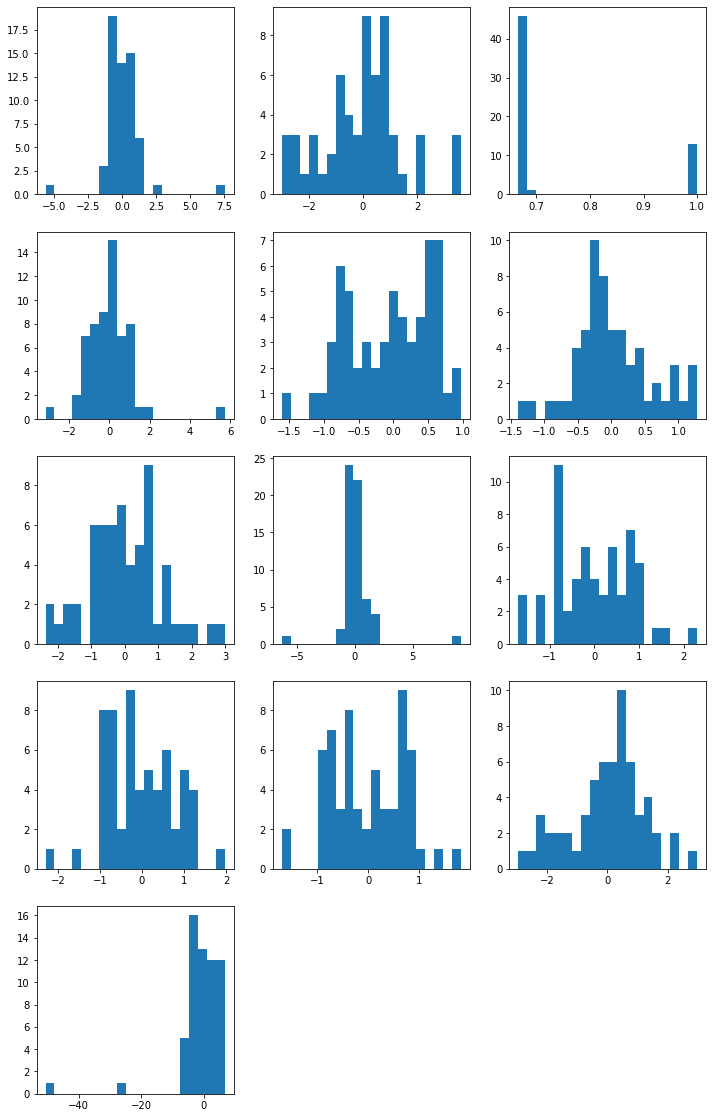

In [ ]:
columns = train.drop(columns='sequence').columns
plt.figure(figsize=(12,20))
for i,column in enumerate(columns):
  plt.subplot(5,3,i+1)
  plt.hist(train[train['sequence']==0][column],bins=20)
plt.show()


- 센서 데이터이고 센서마다 분포 형태가 너무 달라 이상치를 정의하기 힘듬 
- 따라서 이상치에 강한 robust scaling 진행 

### 스케일링 
- 스케일링은 우선 Robust Scaling 진행, 추후 submission score 보고 변경 
- Seqeunce 별로 스케일링을 할 지 혹은 센서 전체 데이터를 ㄱㅣ준으로 할 지 정해야 함 
    - Sequence 별로 편차가 클 경우 Sequence 별로 진행 
    - 반대로 Sequence 별로 편차가 적을 경우 센서 전체 데이터를 기준으로 진행 

#### Sequence 편차 확인 
- Sequence 가 너무 많으므로 랜덤 추출 해서 진행 

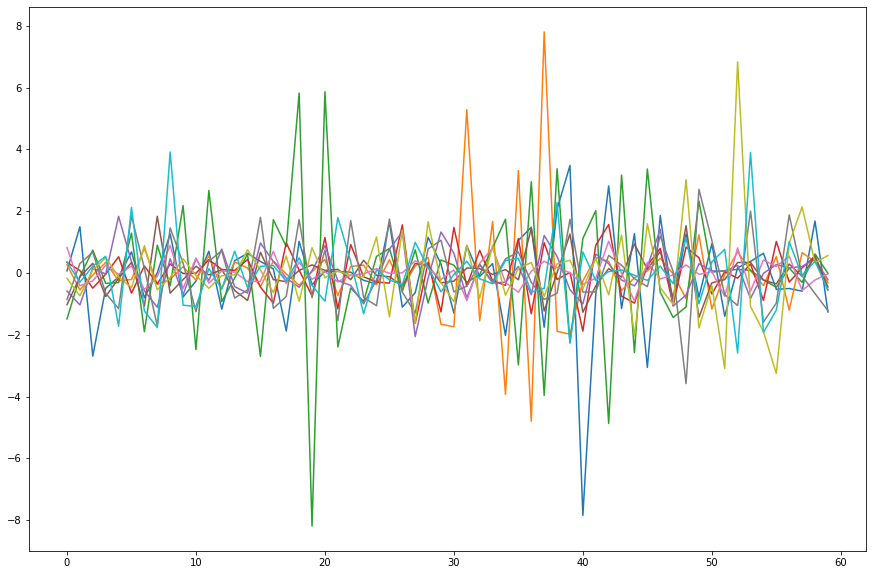

In [ ]:
#확인할 센서 컬럼 
column = columns[0]

#랜덤 추출 
np.random.seed(42)
sequences = np.random.randint(0,25967,10)

plt.figure(figsize=(15,10))
for sequence in sequences:
  plt.plot(np.arange(60),train[train['sequence']==sequence][column])
plt.show()

- 시퀸스 별로 편차가 큼 
- 맞춰야 하는 라벨이 0과 1 (볼과 스트라이크)인 점을 고려했을 때 전체 데이터 보다는 해당 시퀸스의 센서 움직임이 더 클 것이라 생각 
- 따라서 시퀸스 별로 스케일링 진행 

In [ ]:
def robust_scailng(sequence_train):
  output = {}
  output['Q3'] = np.percentile(sequence_train,75)
  output['Q1'] = np.percentile(sequence_train,25)
  output['scailed_data'] = (sequence_train-output['Q1'])/(output['Q3']-output['Q1'])
  return output 

In [ ]:
sequences = np.unique(train['sequence'])
columns = train.drop(columns='sequence').columns
for sequence in tqdm(sequences):
  sequence_train= train.loc[train['sequence']==sequence].drop(columns=['sequence'])
  scailed_data = robust_scailng(sequence_train)['scailed_data']
  train.loc[train['sequence']==sequence,columns] = scailed_data

  0%|          | 0/25968 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

를 하려고 했지만 너무나 오래 걸리는 시간 탓에 그냥 전체 데이터로 스케일링 진행 

In [ ]:
columns = train.drop(columns=['sequence']).columns
temp_train = train.drop(columns=['sequence'])
scailed_data = robust_scailng(temp_train)['scailed_data']
train[columns]= scailed_data

### 그루핑 및 train-valid-test split 

In [ ]:
def split_data(input=np.array):
  split_index = int(len(input)*0.1)
  train = input[:split_index*8]
  valid = input[split_index*8:split_index*9]
  test = input[split_index*9:]
  return (train,valid,test)

In [ ]:
x = np.array(train.drop(columns=['sequence'])).reshape(-1,60,13)
y = np.array(train_labels.drop(columns=['sequence']))

(train_x,valid_x,test_x), (train_y,valid_y,test_y) = split_data(x),split_data(y)

## 3단계 ML 실행 

In [ ]:
train['state']=0
for sequence in tqdm(sequences):
  train.loc[train['sequence']==sequence,'state'] = train_labels[train_labels['sequence']==sequence]['state'].values[0]

  0%|          | 0/25968 [00:00<?, ?it/s]

In [ ]:
train_labels['state'].value_counts()

1    13014
0    12954
Name: state, dtype: int64

In [ ]:
train['state'].value_counts()/60

1    13014.0
0    12954.0
Name: state, dtype: float64

In [ ]:
sup = setup(train, target = 'state', train_size = 0.8)

,Description,Value
0,session_id,4785
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1558080, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
top5 = compare_models(sort='Accuracy', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8747,0.9426,0.8698,0.8789,0.8743,0.7494,0.7495,36.238
rf,Random Forest Classifier,0.6196,0.6663,0.6242,0.6194,0.6218,0.2392,0.2392,592.087
lightgbm,Light Gradient Boosting Machine,0.6045,0.6464,0.6603,0.5949,0.6259,0.2089,0.2102,14.376
gbc,Gradient Boosting Classifier,0.5896,0.6238,0.6391,0.5824,0.6094,0.1791,0.1800,407.805
ada,Ada Boost Classifier,0.5800,0.6102,0.5990,0.5780,0.5883,0.1600,0.1601,87.306
dt,Decision Tree Classifier,0.5671,0.5671,0.5662,0.5682,0.5672,0.1342,0.1342,33.759
lr,Logistic Regression,0.5377,0.5562,0.6448,0.5319,0.5829,0.0751,0.0768,5.411
qda,Quadratic Discriminant Analysis,0.5047,0.5252,0.9757,0.5029,0.6637,0.0075,0.0227,1.723
nb,Naive Bayes,0.5044,0.5261,0.9751,0.5028,0.6634,0.0070,0.0209,0.795
ridge,Ridge Classifier,0.5041,0.0000,0.5876,0.5044,0.5428,0.0079,0.0080,0.833


- (질문)머신러닝에서 시계열 데이터의 shape은 어떻게....?

#차원 축소 베이스라인 

In [ ]:
file_dirs = glob('*.csv')

df = []
for dir in file_dirs:
  exec(f"{dir.split('.')[0]}=pd.read_csv('{dir}')")
  df.append(dir.split('.')[0])

In [ ]:
train.drop(columns = ['subject','step'],inplace=True)

In [ ]:
#차원축소 : 표준편차 
df = []
sequences = np.unique(train['sequence'])
for sequence in tqdm(sequences):
  std_value = np.std(train[train['sequence']==sequence].drop(columns='sequence'),axis=0)
  df.append(std_value)
df = pd.DataFrame(df)
df['sequence'] = sequences
df['state']= train_labels['state']

  0%|          | 0/25968 [00:00<?, ?it/s]

In [ ]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sequence,state
0,1.419679,1.496592,0.137143,1.141015,0.602636,0.564861,1.081107,1.606681,0.852348,0.804449,0.727153,1.247191,8.138202,0,0
1,1.580568,0.941458,0.487898,1.830964,0.824793,2.690574,1.278711,1.841956,1.090967,1.158314,1.594104,1.759973,49.870433,1,1
2,1.137923,0.797157,0.168910,0.952628,2.033272,2.440086,0.895716,2.193999,1.689250,0.839220,2.230940,0.606024,0.358033,2,1
3,1.754896,1.898844,0.195813,1.747123,0.248697,1.177696,1.593503,2.080962,1.969723,2.554428,0.445206,1.387782,0.239685,3,1
4,1.997919,1.373659,0.163504,1.885039,0.535736,2.015274,2.500457,1.690919,0.979017,1.109457,0.339138,2.870403,0.051169,4,1


In [ ]:
len(df)

25968

In [ ]:
#스케일링
df_dict = robust_scailng(df.drop(columns=['sequence','state']))
df[df.columns[:-2]] = df_dict['scailed_data']

In [ ]:
sup = setup(df, target = 'state', train_size = 0.8)

,Description,Value
0,session_id,3258
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
top5 = compare_models(sort='Accuracy', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7521,0.8261,0.7923,0.7315,0.7607,0.5044,0.5062,2.265
lightgbm,Light Gradient Boosting Machine,0.7468,0.8200,0.8007,0.7210,0.7587,0.4940,0.4971,0.410
rf,Random Forest Classifier,0.7455,0.8185,0.7854,0.7254,0.7542,0.4911,0.4928,5.717
gbc,Gradient Boosting Classifier,0.7346,0.8048,0.7912,0.7088,0.7477,0.4695,0.4727,7.123
ada,Ada Boost Classifier,0.7230,0.7882,0.7657,0.7034,0.7332,0.4463,0.4481,1.639
knn,K Neighbors Classifier,0.6568,0.7088,0.6922,0.6441,0.6672,0.3138,0.3148,0.598
dt,Decision Tree Classifier,0.6557,0.6557,0.6554,0.6534,0.6543,0.3114,0.3115,0.388
lr,Logistic Regression,0.5665,0.5914,0.4017,0.5951,0.4794,0.1314,0.1390,0.647
ridge,Ridge Classifier,0.5649,0.0000,0.3987,0.5932,0.4767,0.1282,0.1358,0.037
lda,Linear Discriminant Analysis,0.5649,0.5890,0.3987,0.5932,0.4767,0.1282,0.1358,0.067


#차원 축소 + Feature Importance

In [ ]:
idx = int(len(df)*0.8)

8

In [ ]:
train_df_x = df.drop(columns=['sequence','state']).iloc[:idx]
train_df_y = df[['state']].iloc[:idx]

valid_df_x = df.drop(columns=['sequence','state']).iloc[idx:]
valid_df_y = df[['state']].iloc[idx:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(train_df_x,train_df_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Feature Importance

### Permutation 

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(valid_df_x, valid_df_y)
eli5.show_weights(perm, feature_names=train_df_x.columns.tolist())

Weight,Feature
0.1346 ± 0.0093,sensor_02
0.0262 ± 0.0081,sensor_12
0.0193 ± 0.0056,sensor_08
0.0143 ± 0.0061,sensor_04
0.0112 ± 0.0040,sensor_09
0.0072 ± 0.0048,sensor_10
0.0055 ± 0.0037,sensor_01
0.0052 ± 0.0021,sensor_00
0.0044 ± 0.0028,sensor_11
0.0025 ± 0.0033,sensor_07


### variance_inflation_factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_df_x.values, i) for i in range(train_df_x.shape[1])]
vif["features"] = train_df_x.columns
vif.sort_values(by=['VIF Factor'])

,VIF Factor,features
2,1.023533,sensor_02
8,1.111606,sensor_08
5,1.315863,sensor_05
12,1.362564,sensor_12
4,1.717037,sensor_04
10,1.760104,sensor_10
1,1.900038,sensor_01
9,2.046639,sensor_09
3,2.102729,sensor_03
6,2.202947,sensor_06


In [ ]:
sup = setup(df[['sensor_02','sensor_12','sensor_08','sensor_04','sensor_09','sensor_10','sensor_01','sensor_00','sensor_11','state']], target = 'state', train_size = 0.8)
top5 = compare_models(sort='Accuracy', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7488,0.8225,0.7991,0.7295,0.7627,0.4970,0.4994,2.140
lightgbm,Light Gradient Boosting Machine,0.7464,0.8201,0.8018,0.7252,0.7615,0.4921,0.4950,0.301
rf,Random Forest Classifier,0.7451,0.8161,0.7905,0.7282,0.7580,0.4897,0.4916,5.674
gbc,Gradient Boosting Classifier,0.7374,0.8054,0.8001,0.7143,0.7548,0.4740,0.4776,5.017
ada,Ada Boost Classifier,0.7257,0.7899,0.7756,0.7088,0.7407,0.4507,0.4528,1.177
dt,Decision Tree Classifier,0.6592,0.6591,0.6634,0.6624,0.6628,0.3183,0.3184,0.265
knn,K Neighbors Classifier,0.6556,0.7014,0.7023,0.6466,0.6732,0.3106,0.3118,0.296
ridge,Ridge Classifier,0.5655,0.0000,0.4576,0.5903,0.5155,0.1329,0.1365,0.024
lda,Linear Discriminant Analysis,0.5655,0.5924,0.4576,0.5903,0.5155,0.1329,0.1365,0.044
lr,Logistic Regression,0.5650,0.5947,0.4576,0.5896,0.5152,0.1320,0.1356,0.144
